### 대한민국 대표 펀드 따라잡기
+ KODEX200(삼성자산운용): https://www.kodex.com
+ TIGER200(미래에셋자산운용): https://www.tigeretf.com
+ 두 펀드 모두 KOSPI200 지수의 변동률과 유사하게 운용하는 것을 목적으로 함
+ 펀드 자산의 95% 이상을 KOSPI200 지수 구성종목인 무식을 매수해서 수익률을 달성하는 방법 채택

+ 대표적인 지수 수익률 복제 방법
  - 지수 구성종목 주식을 그대로 보유 (KODEX200, TIGER200)
  - 지수 선물을 보유 (파생형 펀드로 자산을 굴리는 방법이 다양해진다는 장점이 있지만 자산 모집에 한계 있음 <- 퇴직연금, IRP 같은 안전자산은 파생형 펀드 투자가 불가능)
                  

#### K10 인덱스 활용하여 인덱스 펀드 만들기
+ K10 펀드 투자설명서 (355pg)
+ 현실보다는 훨씬 단순화
+ 전에 K10 인덱스를 만들 때 썻던 코드 활용

In [1]:
import sys
import os
import pandas as pd
import numpy as np
import re
import json
from bs4 import BeautifulSoup
from urllib.request import urlopen
import datetime as dt
from sklearn.linear_model import LinearRegression
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fname = fm.FontProperties(fname='D:/data_starfish/jupyter/malgun.ttf').get_name()
from IPython.display import Image
mpl.rc('font',family=fname)
import matplotlib.gridspec as gridspec
from jupyterthemes import jtplot
jtplot.style(theme='onedork')
%matplotlib inline
import platform
platform.system()
# 운영체제별 한글 폰트 설정
if platform.system() == 'Darwin': # Mac 환경 폰트 설정
    plt.rc('font', family='AppleGothic')
elif platform.system() == 'Windows': # Windows 환경 폰트 설정
    plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False) # 마이너스 폰트 설정
# 글씨 선명하게 출력하는 설정
%config InlineBackend.figure_format = 'retina'

In [2]:
def stock_info(stock_cd):
    url_float = 'http://companyinfo.stock.naver.com/v1/company/c1010001.aspx?cmp_cd=' + stock_cd
    source = urlopen(url_float).read()
    soup = BeautifulSoup(source, 'lxml')
    
    temp = soup.find(id="cTB11").find_all('tr')[6].td.text
    temp = temp.replace('\r','')
    temp = temp.replace('\n','')
    temp = temp.replace('\t','')
    
    temp = re.split('/', temp)
    
    # 발행주식 수
    outstanding = temp[0].replace(',','') 
    outstanding = outstanding.replace('주','')
    outstanding = outstanding.replace(' ','')
    outstanding = int(outstanding)
    # 유동비율
    floating = temp[1].replace(' ','')
    floating = floating.replace('%','')
    floating = float(floating)
    #종목명
    name = soup.find(id="pArea").find('div').find('div').find('tr').find('td').find('span').text
    
    k10_outstanding[stock_cd] = outstanding
    k10_floating[stock_cd] = floating
    k10_name[stock_cd] = name

In [3]:
'''
한국거래소 시가총액 상위 10종목 (2020년 12월 기준)
005930 삼성전자
000660 SK하이닉스
051910 LG화학
005935 삼성전자(우)
207940 삼성바이오로직스
068270 셀트리온
035420 NAVER
005380 현대차
006400 삼성SDI
035720 카카오
'''

k10_component = ['005930','000660','051910','005935',
                 '207940','068270','035420','005380',
                 '006400','035720']

In [4]:
k10_outstanding = dict()
k10_floating = dict()
k10_name = dict()

for stock_cd in k10_component:
    stock_info(stock_cd)

In [5]:
# K10 구성종목의 종목 정보를 데이터프레임화
tmp = {'Outstanding': k10_outstanding,\
      'Floating': k10_floating,\
      'Name': k10_name}
k10_info = pd.DataFrame(tmp)

In [6]:
# 일자별 주가 수집을 위해 날짜 포맷 정리 함수

def date_format(d):
    
    d = str(d)
    d = d.replace('/','-')
    d = d.replace('.','-')
    
    yyyy = int(d.split('-')[0])
    if yyyy < 50:
        yyyy = yyyy + 2000
    elif yyyy >= 50 and yyyy < 100:
        yyyy = yyyy + 1900
    mm = int(d.split('-')[1])
    dd = int(d.split('-')[2])
    
    return dt.date(yyyy, mm, dd)

In [7]:
def historical_stock_naver(index_cd, start_date='', end_date='', page_n=1, last_page=0):
    
    if start_date:   
        start_date = date_format(start_date)   
    else:    
        start_date = dt.date.today() 
    if end_date:   
        end_date = date_format(end_date)   
    else:   
        end_date = dt.date.today()  
        
        
    naver_stock = \
    'https://finance.naver.com/item/sise_day.nhn?code=' \
    + stock_cd + '&page=' + str(page_n)
    
    source = urlopen(naver_stock).read()
    source = BeautifulSoup(source, 'lxml')   
    
    dates = source.find_all('span', class_='tah p10 gray03')  
    prices = source.find_all('td', class_='num')
    
    for n in range(len(dates)):
        
        if len(dates) > 0:
            
            this_date = dates[n].text
            this_date= date_format(this_date)
            
            if this_date <= end_date and this_date >= start_date:   

                this_close = prices[n*6].text
                this_close = this_close.replace(',', '')
                this_close = float(this_close)

                historical_prices[this_date] = this_close
                
            elif this_date < start_date:   

                return historical_prices              
            
    # 페이지 네비게이션
    if last_page == 0:
        last_page = source.find_all('table')[1].find('td', class_='pgRR').find('a')['href']
        last_page = last_page.split('&')[1]
        last_page = last_page.split('=')[1]
        last_page = int(last_page) 
        
    # 다음 페이지 호출
    if page_n < last_page:   
        page_n = page_n + 1   
        historical_stock_naver(index_cd, start_date, end_date, page_n, last_page)   
        
    return historical_prices

In [8]:
# 2020년 1월 1일부터 2020년 12월 28일까지의 시세 수집

k10_historical_prices = dict()
for stock_cd in k10_component:
    historical_prices = dict()
    start_date = '2020-01-01'
    end_date = '2020-12-28'
    historical_prices = historical_stock_naver(stock_cd,start_date,end_date)
    
    k10_historical_prices[stock_cd] = historical_prices

In [9]:
k10_historical_price = pd.DataFrame(k10_historical_prices)
k10_historical_price.sort_index(axis=1, inplace=True)

In [10]:
k10_historical_price = k10_historical_price.fillna(method='bfill')
if k10_historical_price.isnull().values.any():
    k10_historical_price = k10_historical_price.fillna(method='ffill')
    
k10_historical_price.head(3)

,000660,005380,005930,005935,006400,035420,035720,051910,068270,207940
2020-12-28,115500.0,189500.0,78700.0,72900.0,559000.0,281000.0,373000.0,814000.0,333500.0,789000.0
2020-12-24,118000.0,187000.0,77800.0,72800.0,563000.0,282000.0,374000.0,818000.0,347500.0,794000.0
2020-12-23,116000.0,185000.0,73900.0,69900.0,554000.0,284000.0,377500.0,806000.0,355000.0,796000.0


In [11]:
# 유동주식 비율 반영한 시가총액 구하기
k10_historical_mc = k10_historical_price * k10_info['Outstanding'] * k10_info['Floating'] * 0.01
k10_historical_mc.tail(3)

,000660,005380,005930,005935,006400,035420,035720,051910,068270,207940
2020-01-06,5.072595e+13,1.598418e+13,2.472000e+14,2.150087e+14,1.179704e+13,2.318001e+13,9.787128e+12,1.393283e+13,1.768178e+13,6.746845e+12
2020-01-03,5.083353e+13,1.598418e+13,2.472000e+14,2.147735e+14,1.174575e+13,2.330843e+13,9.660434e+12,1.411437e+13,1.814171e+13,6.910603e+12
2020-01-02,5.094111e+13,1.625976e+13,2.458638e+14,2.145382e+14,1.189962e+13,2.343685e+13,9.660434e+12,1.425052e+13,1.839723e+13,7.017046e+12


In [12]:
# 비중 계산을 위한 전체 종목의 시가총액 합 구하기
k10 = pd.DataFrame()
k10['Market Cap'] = k10_historical_mc.sum(axis=1)
k10.head(3)

,Market Cap
2020-12-28,9.540906e+14
2020-12-24,9.527030e+14
2020-12-23,9.206085e+14


In [13]:
# 기준 날짜 = 2020년 1월 2일 (목)
base_date = dt.date(2020,1,2)

In [14]:
# 일자별 K10 인덱스 계산
k10['Index'] = k10['Market Cap'] / k10['Market Cap'][base_date] * 100
k10.tail(3)

,Market Cap,Index
2020-01-06,6.120445e+14,99.964047
2020-01-03,6.126725e+14,100.066617
2020-01-02,6.122646e+14,100.000000


In [15]:
# 그래프로 나타내기
# 사이즈, 그리드 설정
plt.rcParams['figure.figsize'] = (10,5)
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['grid.alpha'] = 0.7
plt.rcParams['lines.antialiased'] = True

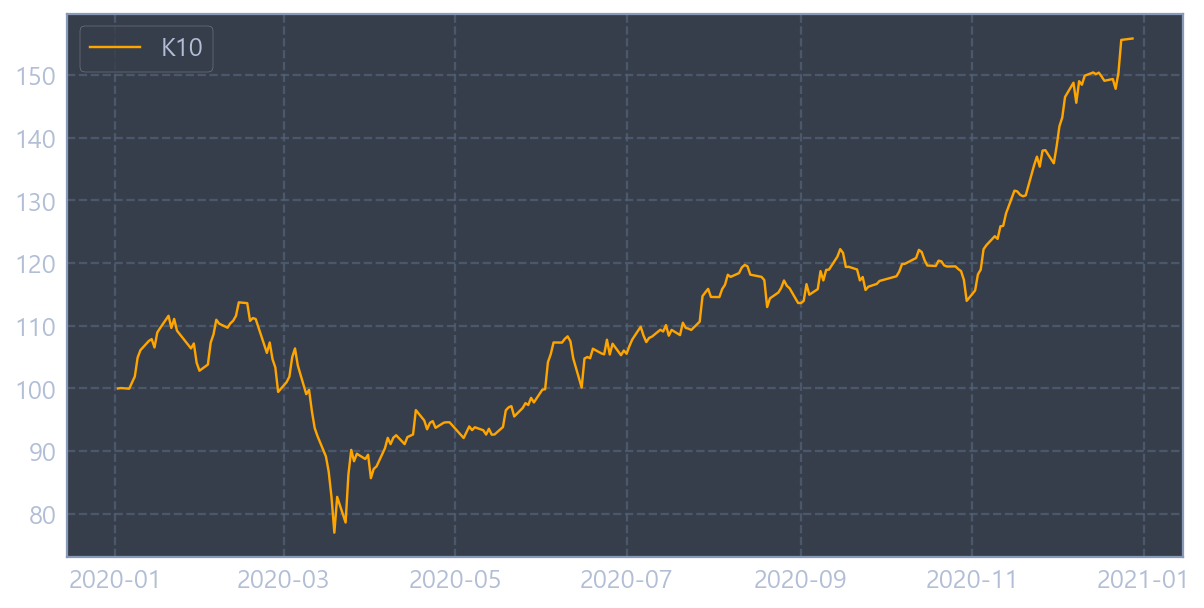

In [16]:
plt.plot(k10['Index'], color='orange', label='K10')
plt.legend(loc=0)
plt.grid(True)

In [17]:
# KOSPI200과 비교
def historical_index_naver(index_cd, start_date='', end_date='', page_n=1, last_page=0):
    
    if start_date:   
        start_date = date_format(start_date)   
    else:    
        start_date = dt.date.today() 
    if end_date:   
        end_date = date_format(end_date)   
    else:   
        end_date = dt.date.today()  
        
        
    naver_index = \
    'http://finance.naver.com/sise/sise_index_day.nhn?code=' \
    + index_cd + '&page=' + str(page_n)
    
    # 지정한 페이지에서 코드 읽기
    source = urlopen(naver_index).read()
    # 뷰티풀 스프로 태그별로 코드 분류
    source = BeautifulSoup(source, 'lxml')   
    
    # <td class="date">태그에서 날짜 수집   
    dates = source.find_all('td', class_='date')  
    # <td class="number_1">태그에서 지수 수집
    prices = source.find_all('td', class_='number_1')  
    
    for n in range(len(dates)):
    
        if dates[n].text.split('.')[0].isdigit():
            
            # 날짜 처리
            this_date = dates[n].text
            this_date= date_format(this_date)
            
            if this_date <= end_date and this_date >= start_date:   
            # start_date와 end_date 사이에서 데이터 저장
                # 종가 처리
                this_close = prices[n*4].text   # 0,4,8...
                this_close = this_close.replace(',', '')
                this_close = float(this_close)

                # 딕셔너리에 저장
                historical_prices[this_date] = this_close
                
            elif this_date < start_date:   
            # start_date 이전이면 함수 종료
                return historical_prices              
            
    # 페이지 네비게이션
    if last_page == 0:
        last_page = source.find('td', class_='pgRR').find('a')['href']
        # 마지막페이지 주소 추출
        last_page = last_page.split('&')[1]
        last_page = last_page.split('=')[1]
        last_page = int(last_page) 
        
    # 다음 페이지 호출
    if page_n < last_page:   
        page_n = page_n + 1   
        historical_index_naver(index_cd, start_date, end_date, page_n, last_page)   
        
    return historical_prices

In [18]:
index_cd = 'KPI200'
historical_prices = dict()
kospi200 = historical_index_naver(index_cd, '2020-1-1', '2020-12-28')
k200 = pd.DataFrame({'Index': kospi200})
k200.tail(3)

,Index
2020-12-23,371.32
2020-12-24,379.18
2020-12-28,379.93


In [19]:
# 수정 지수 칼럼 추가 (K10지수를 KOSPI200과 맞춤)
k10['Adj Index'] = k10['Market Cap'] / k10['Market Cap'][base_date] * k200['Index'][base_date]
k10.head(3)

,Market Cap,Index,Adj Index
2020-12-28,9.540906e+14,155.829777,452.451758
2020-12-24,9.527030e+14,155.603148,451.793742
2020-12-23,9.206085e+14,150.361217,436.573794


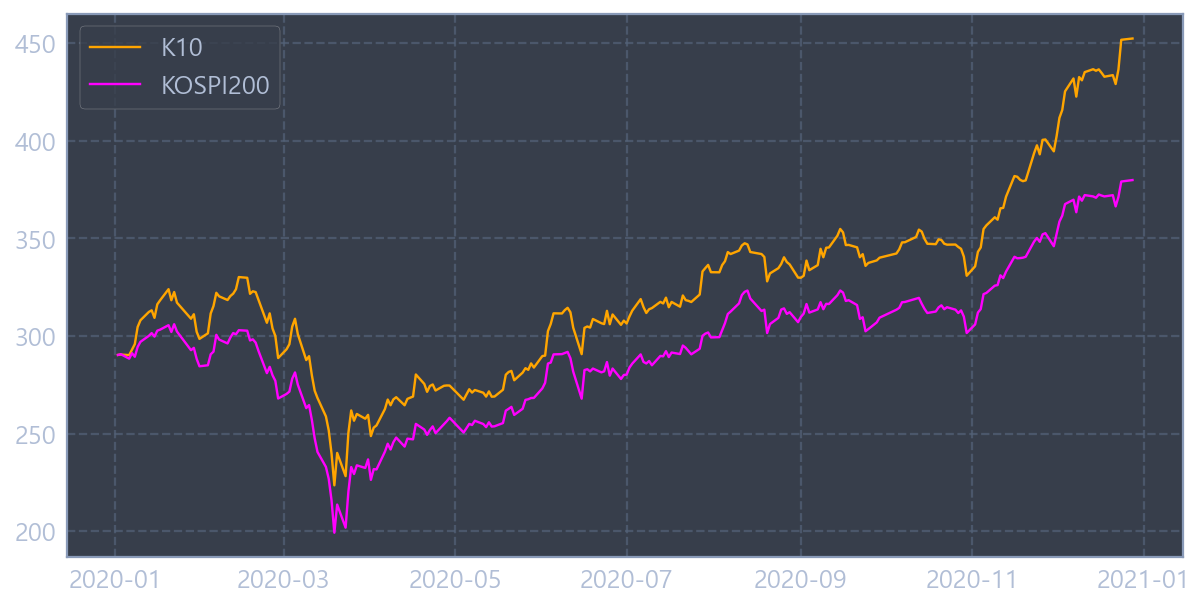

In [20]:
plt.plot(k10['Adj Index'], color='orange', label='K10')
plt.plot(k200['Index'], color='magenta', label='KOSPI200')
plt.legend(loc=0)
plt.grid(True)

#### K10 펀드 설계 및 운용
+ Numpy로 계산

In [21]:
# 펀드 기본정보 세팅
# CU (creation unit: 설정과 환매 단위), 펀드 설정 기준일, 최초 설정 수량, 이자율 (펀드가 보유할 현금에 대한 이자)
CU = 50000 # 설정과 환매 단위
base_date = dt.date(2020,1,2) # 설정 기준일
volume = 1000000 # 최초 설정 수량
interest_rate = 0.02 # 이자율

In [22]:
# 매일 설정과 환매 발생 가능 -> 설정과 환매가 얼마나 많은지 예측할 수 없으므로 random 함수 사용
def creation_redemption(v):
    creation = np.random.randint(0,5) * CU # 0과 5 사이 임의의 정수
    if v>500000: # 50만 좌 이상인 경우에만 환매 발생
        redemption = np.random.randint(0,5) * CU
    else:
        redemption = 0
    volume = v + creation - redemption # 총 좌수 = 기존 좌수 + 설정 - 환매
    return(creation, redemption, volume)

In [23]:
# 보유 비중 산정
k10_stock_ratio = pd.DataFrame()
for s in k10_info.index:
    k10_stock_ratio[s] = k10_historical_mc[s] / k10_historical_mc.sum(axis=1)
    
k10_stock_ratio.tail(3)

,005930,000660,051910,005935,207940,068270,035420,005380,006400,035720
2020-01-06,0.403892,0.082880,0.022764,0.351296,0.011023,0.028890,0.037873,0.026116,0.019275,0.015991
2020-01-03,0.403478,0.082970,0.023037,0.350552,0.011279,0.029611,0.038044,0.026089,0.019171,0.015768
2020-01-02,0.401565,0.083201,0.023275,0.350401,0.011461,0.030048,0.038279,0.026557,0.019435,0.015778


In [35]:
Fund_NAV = pd.DataFrame()
Fund_Chg = pd.DataFrame()

for d in k10_historical_price.index:
    
    # 포트폴리오 구성용 정보 (당일 주가 / 자산비중)
    stock_price = np.array(k10_historical_price.loc[d])
    stock_weight = np.array(k10_stock_ratio.loc[d])
    
    # 신규 펀드 설정/환매 좌수 계산
    if (d == base_date):
        volume = 0 # 펀드 좌수
        volume_chg = 1000000 # 첫날 설정액
    else:
        vol = creation_redemption(volume) # 설정/환매 함수 호출
        volume_chg = vol[0] - vol[1] # 좌수 변동 
    
    # 기존 주식 포트폴리오 NAV 계산
    if (d <= base_date): # 기준일 이전
        # 최초 주식 포트폴리오 (보유량 0)
        stock_holdings = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
        NAV_cash = 0 # 최초 현금 보유량
    else: # 기준일 이후
        # stock_holdings =  np.floor(CU * volume * stock_weight)
        NAV_stock = sum(stock_holdings * stock_price) # 주식 잔고
        # NAV_cash = (CU * volume) - NAV_stock
        NAV = NAV_stock + NAV_cash # 전체 잔고
        
    # 기준가격 산정
    if (d <= base_date):
        # 최초 기준가를 기준일자의 KOSPI 200 지수와 맞춤
        price = k200['Index'][base_date] * 100
    else:
        price = NAV / volume
        
    # 총 펀드 좌수에 반영
    volume = volume + volume_chg
    # 펀드 입출금액
    aum_chg = price * volume_chg
    
    # 신규 주식 거래량 계산
    stock_trade = np.floor( price * volume_chg * stock_weight / stock_price )    
    # 주식 매매금액
    trade_amt = sum(stock_trade * stock_price)
    # 현금 잔고 변동 
    cash_chg = aum_chg - trade_amt
    
    # 총 주식 보유량 = 기 보유량 + 신규 거래량
    stock_holdings = stock_holdings + stock_trade
    # 현금 보유량 증가 (이자율 반영)
    cash_holdings = np.floor( NAV_cash * np.exp(interest_rate/365) ) 

    # NAV 업데이트
    NAV_stock = sum(stock_holdings * stock_price)     # 주식 잔고
    NAV_cash = cash_holdings + cash_chg     # 현금 잔고
    NAV = NAV_stock + NAV_cash     # 전체 잔고

    date = pd.Series(d)
    
    # Fund NAV 정보를 DataFrame에 저장
    NAV_tmp = {'Stock' : NAV_stock, 'Cash' : NAV_cash, 'Total' : NAV, 'Price' : price}
    tmp = pd.DataFrame(NAV_tmp, index=date)
    Fund_NAV = Fund_NAV.append(tmp)
    
    # 일자별 설정&환매 좌수 정보를 DataFrame에 저장
    Chg_tmp = {'Amount Change' : aum_chg, 'Trade Amount' : trade_amt, 'Cash Change' : cash_chg}
    tmp = pd.DataFrame(Chg_tmp, index=date)
    Fund_Chg = Fund_Chg.append(tmp)

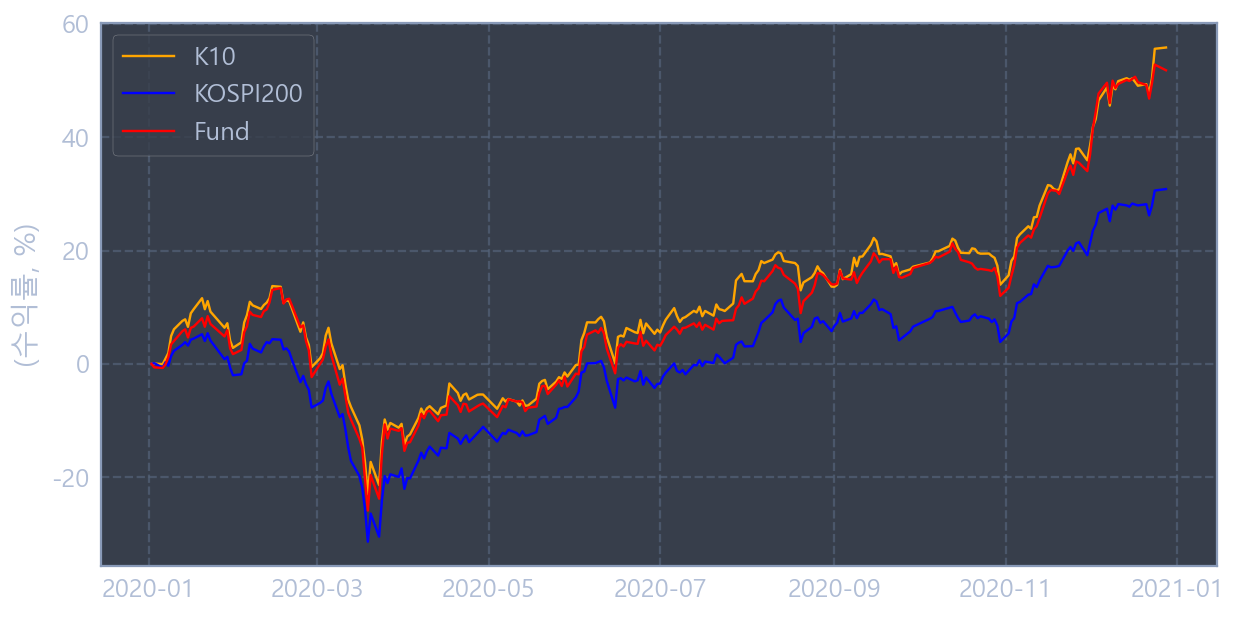

In [36]:
# 펀드 수익률 vs. 지수 수익률
# YTD(year to date) 수익률 비교
Earnings = pd.DataFrame()
Earnings['K10'] = ( k10['Index'] - k10['Index'][base_date] ) / k10['Index'][base_date] * 100
Earnings['KOSPI200'] = ( k200['Index'] - k200['Index'][base_date] ) / k200['Index'][base_date] * 100
Earnings['Fund'] = ( Fund_NAV['Price'] - Fund_NAV['Price'][base_date] )/ Fund_NAV['Price'][base_date] * 100
ax = Earnings.plot(color = ['orange', 'blue', 'red'])
ax.legend(loc=0)
ax.set_ylabel('(수익률, %)')
ax.grid(True)

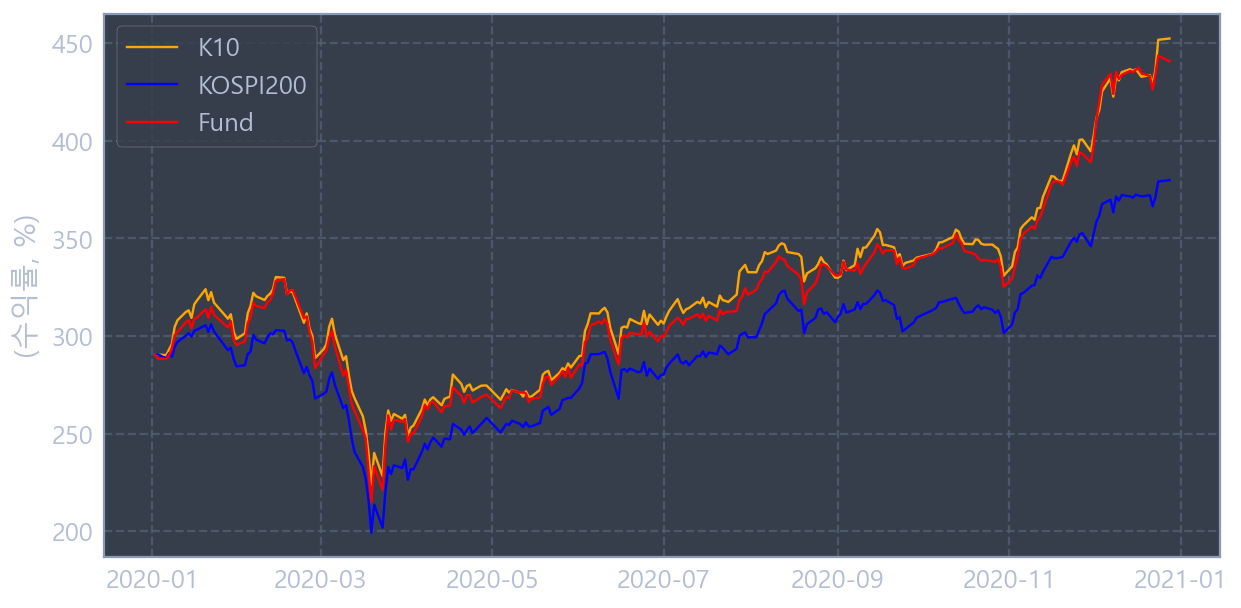

In [37]:
# 펀드 기준가 vs. 지수
Indicator = pd.DataFrame()
Indicator['K10'] = k10['Adj Index']
Indicator['KOSPI200'] = k200['Index']
Indicator['Fund'] = Fund_NAV['Price']/100
ax = Indicator.plot(color = ['orange','blue','red'])
ax.legend(loc=0)
ax.set_ylabel('(수익률, %)')
ax.grid(True)

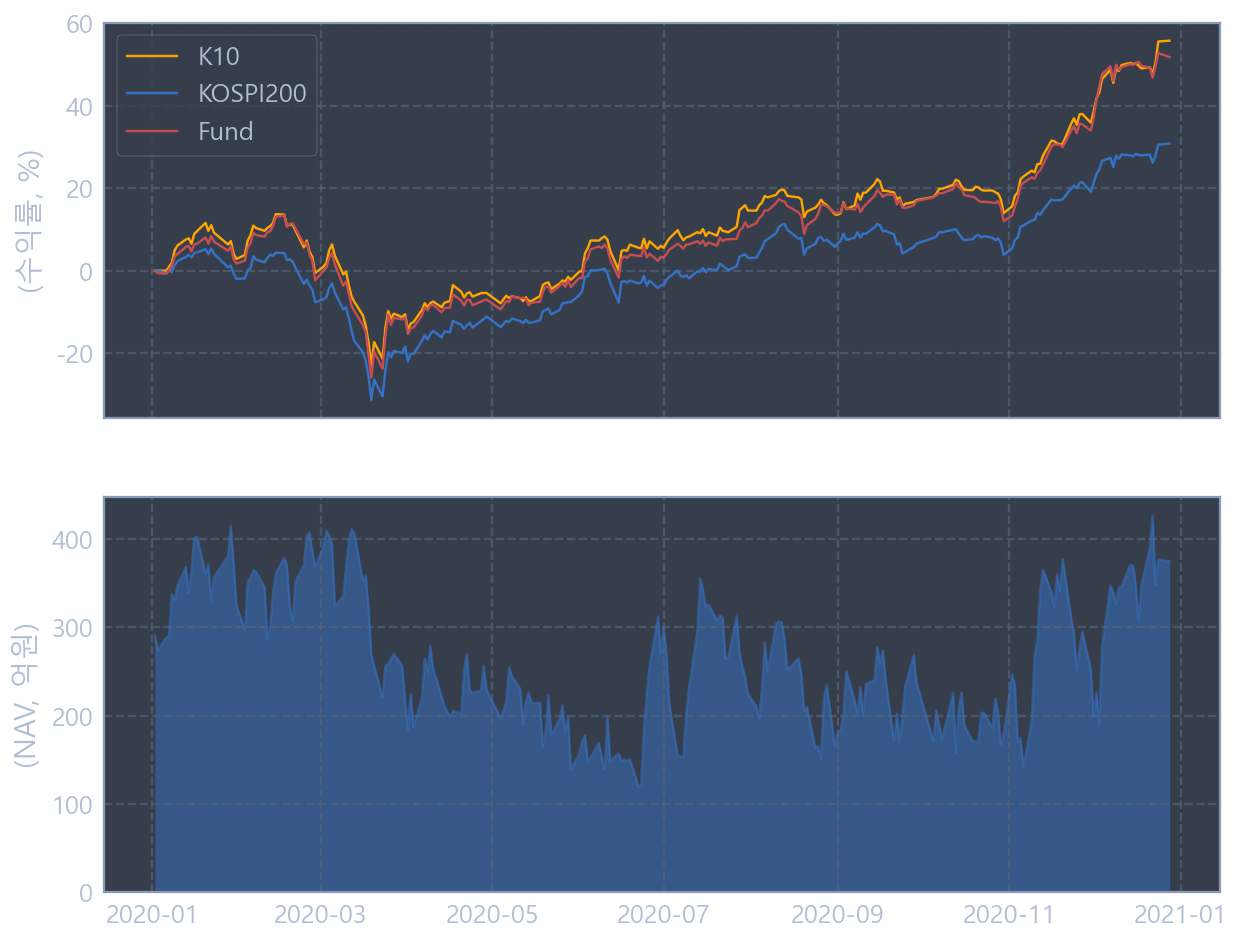

In [38]:
# 수익률과 NAV의 변동
fig = plt.figure(figsize=(10,8))
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)
Earnings.plot.line(ax=ax1, color=['orange','b','r'])
ax1.set_ylabel('(수익률, %)')
Fund_NAV['Display'] = Fund_NAV['Total'] * 0.00000001 # 억 단위로
Fund_NAV['Display'].plot.area(ax=ax2, stacked=False, sharex=True)
ax2.set_ylabel('(NAV, 억원)')
ax1.grid(True)
ax2.grid(True)

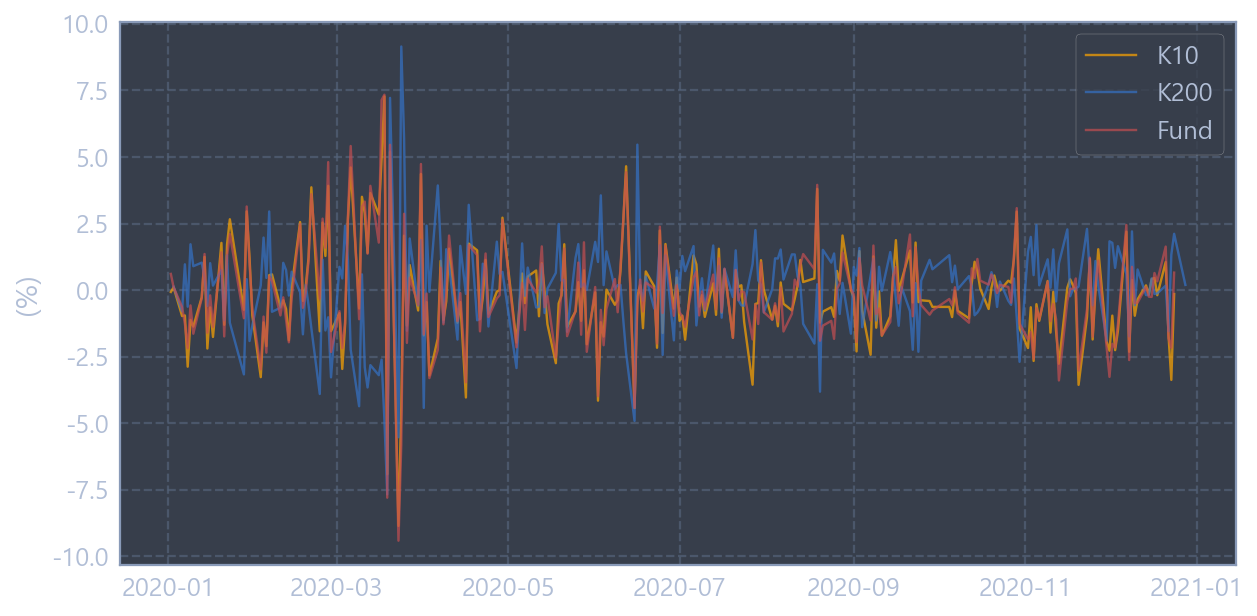

In [39]:
# 일간 수익률
# 전일 날짜의 시세를 하루씩 뒤로 당길 때... DataFrame.shift(1)
# 앞으로 당길 때... DataFrame.shift(-1)
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
Daily = pd.DataFrame()
Daily['K10'] = (k10['Index'] - k10['Index'].shift(1)) \
                / k10['Index'].shift(1) * 100
Daily['K200'] = (k200['Index'] - k200['Index'].shift(1)) \
                / k200['Index'].shift(1) * 100
Daily['Fund'] = (Fund_NAV['Price'] - Fund_NAV['Price'].shift(1)) \
                / Fund_NAV['Price'].shift(1) * 100
Daily.plot(ax=ax, color=['orange','b','r'], alpha=0.7)
ax.set_ylabel('(%)')
ax.grid(True)

#### 펀드의 추적오차
1. 일간 추적오차 = 펀드 수익률 - 지수 수익률
2. 기간별 추적오차 = $ \sqrt{\sum_{i=1}^n(펀드 수익률 - 지수 수익률)^2 \over n-1} $

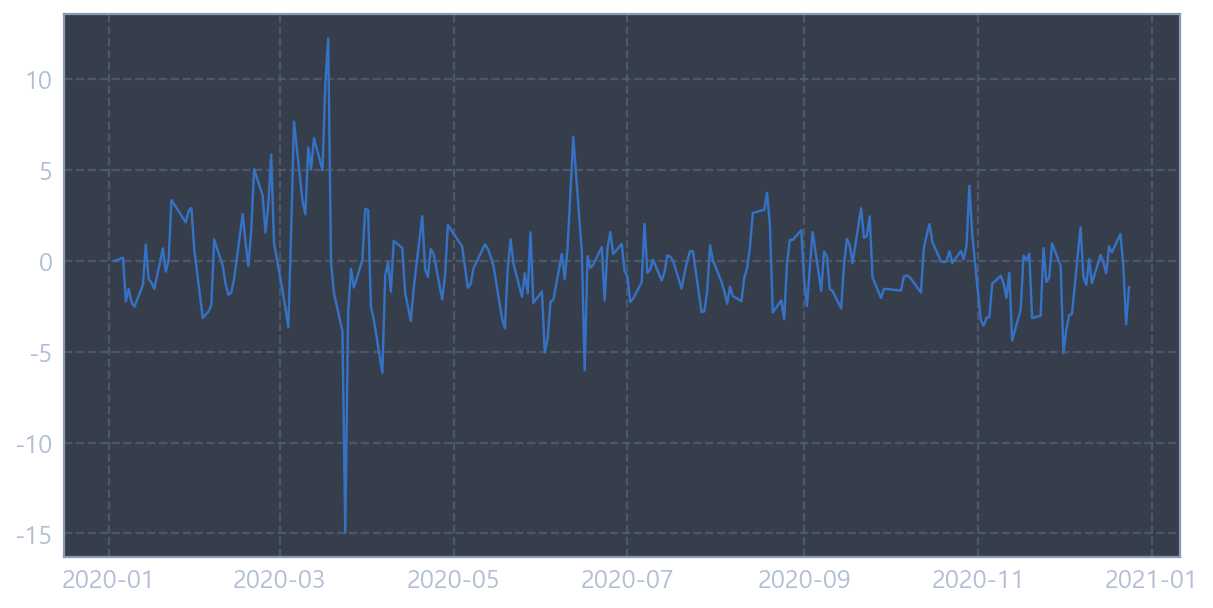

In [40]:
# 여기선 펀드의 일간 추적오차를 구하는 것이므로 1번 이용
# KOSPI200 대비 일간 추적오차율
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
Daily['TE200'] = Daily['Fund'] - Daily['K200']
Daily['TE200'].plot(ax=ax)
ax.grid(True)

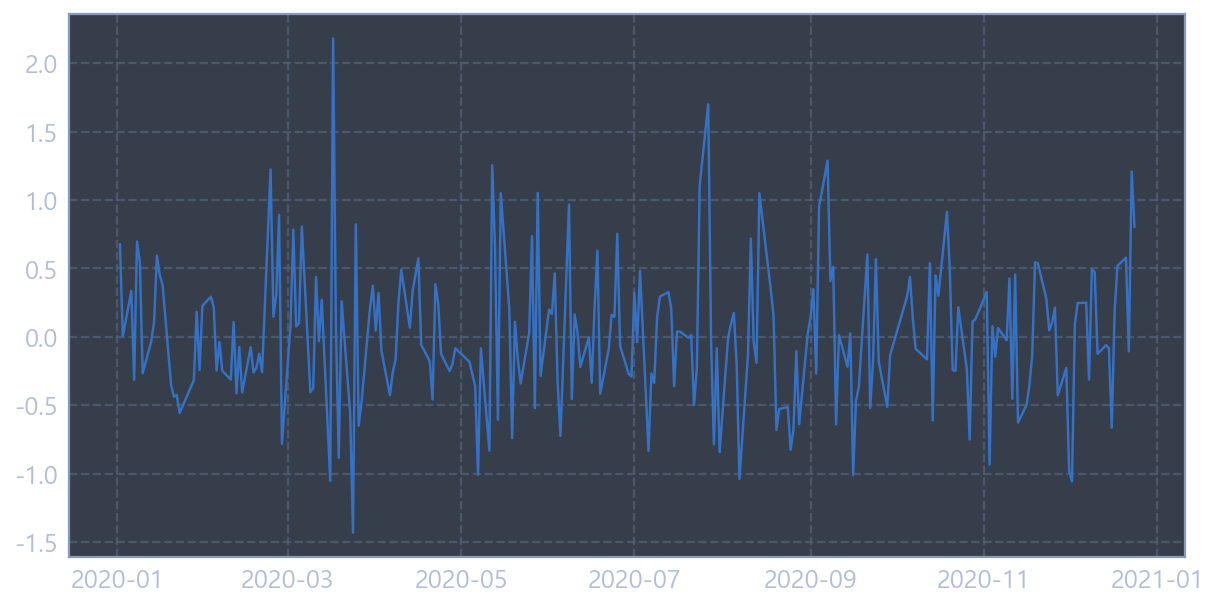

In [41]:
# K10 대비 일간 추적오차율
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
Daily['TE10'] = Daily['Fund'] - Daily['K10']
Daily['TE10'].plot(ax=ax)
ax.grid(True)